In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from functools import reduce, lru_cache
from importlib import reload
from typing import Iterable, Dict, Tuple
import datetime as dt
import copy

np.set_printoptions(precision=5)
%matplotlib inline
sns.set_style('darkgrid')
sns.set_theme(rc={'figure.figsize':(8, 6)})

In [2]:
from loader import load_history

In [3]:
YEARDAYS = 250

In [4]:
def calc_return_volatility(price, n_days=YEARDAYS):
    price = price.dropna()
    log_price = np.log(price)
    log_ret = log_price - log_price.shift(1)
    log_ret_mean = log_ret.mean() * n_days
    log_ret_std = log_ret.std() * np.sqrt(n_days)
    ret = np.exp(log_ret_mean) - 1
    volatility = np.exp(log_ret_std) - 1
    return ret, volatility

In [5]:
def calc_mdd(price: pd.DataFrame) -> pd.DataFrame:
    drawdown = 1 - price / price.cummax()
    return drawdown

def calc_return_mdd(price, n_days=YEARDAYS):
    price = price.dropna()
    log_price = np.log(price)
    log_ret = log_price - log_price.shift(1)
    log_ret_mean = log_ret.mean() * n_days
    ret = np.exp(log_ret_mean) - 1
    _mdd = calc_mdd(price)
    _mdd_low10 = _mdd.quantile(0.9)
    return ret, _mdd_low10


In [6]:
def calc_df_risk_return(df: pd.DataFrame, fn=calc_return_mdd):
    df_dict = {
        'symbol': [],
        'risk': [],
        'return': [],
    }
    for sym in df.columns:
        ret, risk = fn(df[sym].dropna())
        df_dict['symbol'].append(sym)
        df_dict['risk'].append(risk)
        df_dict['return'].append(ret)

    return pd.DataFrame.from_dict(df_dict)

In [7]:
def merge_price_two(a, b):
    return pd.concat([a, b], axis=1)
def merge_price(dfs: Dict[str, pd.DataFrame], target='adj_hlc3') -> pd.DataFrame:
    renamed = {
        sym: d[target].rename(sym)
        for sym, d in dfs.items()
    }
    return reduce(merge_price_two, renamed.values())

In [8]:
def normalize_price(df: pd.DataFrame):
    ret = df.apply(lambda s: s / s.dropna().iloc[0])
    return ret

In [9]:
def blend(a, b, r=0.5):
    return a*r + b*(1-r)

def get_blend_variants(price, a, b):
    aa, bb = price[a], price[b]
    aa, bb = aa / aa.iloc[0], bb / bb.iloc[0]
    df_dict = {
        a: aa
    }
    for i in range(9, 0, -1):
        df_dict[f'{a}{i}_{b}{10-i}'] = blend(aa, bb, r=i/10)
    df_dict[b] = bb

    blended = pd.DataFrame(df_dict)
    return blended

def plot_riskreturn(price_df, ax=None, fn=calc_return_mdd) -> pd.DataFrame:
    rr = calc_df_risk_return(price_df, fn=fn)
    sns.scatterplot(rr, x='risk', y='return', hue='symbol', ax=ax)
    if ax is None:
        plt.show()
    return rr

In [10]:
def interests_to_balance(inter_df: pd.DataFrame, st, ed):
    st, ed = map(pd.Timestamp, (st, ed))
    drange = pd.date_range(start=pd.Timestamp(st), end=pd.Timestamp(ed), freq='D')
    ret = inter_df.copy()
    ret = ret.reindex(ret.index.append(pd.Index([ed]))).ffill()
    ret = ret.reindex(drange, method='ffill')
    cum_log = (np.log(1 + ret['interest']/100) / 365).cumsum()
    ret['balance'] = np.exp(cum_log)
    return ret

In [11]:
def rebalance(price_df: pd.DataFrame, weights: Dict[str, float], name='rebal'):
    values = []
    wsum = sum(weights.values())
    weights = {_k: _v/wsum for _k, _v in weights.items()}
    portfolio = copy.deepcopy(weights)
    bdays = df.copy()
    bdays['quarter'] = bdays.index.to_period('Q')
    rebal_dates = list(
        bdays.groupby('quarter')
        .apply(lambda x: x.index.min(), include_groups=False)
    )

    def calc_portfolio_value(d):
        return sum(map(lambda ti: portfolio[ti] * price_df.loc[d, ti], portfolio))

    for date in df.index:
        d_value = calc_portfolio_value(date)
        if date in rebal_dates:
            for ticker in portfolio:
                portfolio[ticker] = d_value * weights[ticker] / df.loc[date, ticker]
        values.append({'date': date, name: d_value})

    portfolio_df = pd.DataFrame(values)
    portfolio_df.set_index('date', inplace=True)
    return portfolio_df

In [12]:
def get_rebal_variants(price, a, b):
    rebals = [price[a]]
    for i in range(9, 0, -1):
        w = {a: i/10, b: 1 - i/10}
        name = f'{a}{i}_{b}{10-i}'
        rebals.append(rebalance(price, w, name=name))
    rebals.append(price[b])
    return pd.concat(rebals, axis=1)

In [13]:
inter_df = pd.read_csv(
    'resources/korean_interest_changes.csv',
    index_col='date',
    parse_dates=['date']
)
cash_df = interests_to_balance(
    inter_df,
    st='2000-01-01',
    ed='2026-12-31'
)
cash_df = cash_df.rename(columns={'balance': 'cash'})
cash_df

,interest,cash
2000-01-01,4.75,1.000127
2000-01-02,4.75,1.000254
2000-01-03,4.75,1.000381
2000-01-04,4.75,1.000509
2000-01-05,4.75,1.000636
...,...,...
2026-12-27,2.75,2.133302
2026-12-28,2.75,2.133460
2026-12-29,2.75,2.133619
2026-12-30,2.75,2.133777


In [14]:
tmp='^NDX30T'
TARGETS = [
    'SPY',  # s&p 500
    'SCHD',
    'QQQ',  # 나스닥 100
    'VTI',  # 뱅가드 미국전체
    'VUG',  # 뱅가드 성장주
    # 'VIV',  # 뱅가드 가치주
    # 'VGK',  # 뱅가드 유럽주
    # 'SOXX', # 반도체지수
    'GLD',  # 금
    'BND',  # 뱅가드 미국채
    # 'TLT',  # 장기 미국채
    'BRK-B',
    # 'FUTY',  # 경기방어
    'SPHD',  # 경기방어
    'VDC',  # 경기방어
    # 'SHY',  # 단기미국채
    # 'KO',
    # tmp,
    # 'NVDA',
]
df_tickers = {
    sym: load_history(sym) for sym in TARGETS
}
df_tickers[tmp] if tmp in TARGETS else df_tickers['SPHD']

,open,high,low,close,volume,hlc3,adj_hlc3,shares
date,,,,,,,,
2012-10-26,15.570958,15.570958,15.477905,15.539940,89700,15.560619,15.560619,1.000000
2012-10-31,15.564762,15.633002,15.514514,15.546151,23600,15.581305,15.581305,1.000000
2012-11-01,15.608185,15.633000,15.570964,15.589574,43300,15.610253,15.610253,1.000000
2012-11-02,15.657806,15.657806,15.384849,15.384849,50000,15.566820,15.566820,1.000000
2012-11-05,15.384855,15.384855,15.235969,15.316616,30200,15.362108,15.362108,1.000000
...,...,...,...,...,...,...,...,...
2025-03-07,49.669998,50.689999,49.655998,50.580002,1114300,50.313333,92.571081,1.839892
2025-03-10,50.560001,51.605000,50.380001,50.669998,1480000,50.945000,93.733280,1.839892
2025-03-11,50.549999,50.570000,49.439999,49.590000,1222900,50.236666,92.430023,1.839892


In [15]:
df_raw = merge_price(df_tickers, target='adj_hlc3')
df_raw = pd.merge(df_raw, cash_df['cash'], left_index=True, right_index=True)

def set_start(start, rescale=True) -> pd.DataFrame:
    print(f'df: start from {start}')
    _df: pd.DataFrame = df_raw.loc[df_raw.index > start]
    if rescale:
        # base_price = _df.resample('ME').mean().iloc[0]
        _df: pd.DataFrame = _df.apply(lambda s: s / s.dropna().resample('ME').mean().iloc[0])
    return _df

df_raw

,SPY,SCHD,QQQ,VTI,VUG,GLD,BND,BRK-B,SPHD,VDC,cash
2005-01-03,83.186578,NaN,34.260657,40.957870,41.531964,43.056666,NaN,58.473334,NaN,34.376070,1.234186
2005-01-04,82.319507,NaN,33.777681,40.471931,41.103645,42.816667,NaN,57.739999,NaN,34.145109,1.234294
2005-01-05,81.443320,NaN,33.203232,39.998704,40.610659,42.766666,NaN,57.140001,NaN,34.023327,1.234402
2005-01-06,81.489050,NaN,33.063206,39.968694,40.578324,42.396667,NaN,57.393333,NaN,33.954038,1.234510
2005-01-07,81.589731,NaN,33.146066,39.967536,40.599882,42.106667,NaN,58.133334,NaN,34.216496,1.234618
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-07,905.313130,40.619578,579.229061,439.934422,492.160211,269.273336,152.853088,496.726664,92.571081,396.770410,2.031179
2025-03-10,891.399049,40.882411,566.607622,433.049835,479.560533,267.366669,153.138336,495.850006,93.733280,397.722463,2.031632
2025-03-11,881.753705,40.308957,559.765755,428.052297,473.366248,269.120005,152.846124,497.133331,92.430023,392.087465,2.031783
2025-03-12,884.279209,39.549133,565.423374,429.835655,479.598533,270.010000,152.282585,497.286672,90.726284,385.440917,2.031934


In [16]:
START = pd.Timestamp(2013, 1, 1)
df = set_start(START)
log_df = df.apply(np.log)
monthly_df = df.resample('ME').mean()
df

df: start from 2013-01-01 00:00:00


,SPY,SCHD,QQQ,VTI,VUG,GLD,BND,BRK-B,SPHD,VDC,cash
2013-01-02,0.985536,0.981270,1.000185,0.982914,0.988451,1.010275,1.001406,0.970918,0.978492,0.984643,0.998924
2013-01-03,0.987271,0.983080,1.001328,0.985974,0.990077,1.001548,1.000889,0.982630,0.982297,0.986576,0.998999
2013-01-04,0.989210,0.986585,0.996356,0.988379,0.990529,0.989259,0.999614,0.984622,0.987152,0.987597,0.999073
2013-01-07,0.986911,0.984324,0.993771,0.986630,0.988405,0.985471,0.999695,0.982839,0.986757,0.985665,0.999296
2013-01-08,0.985198,0.981157,0.994318,0.985012,0.987592,0.992182,1.000531,0.982385,0.984671,0.980267,0.999370
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-07,6.099115,5.361110,9.067009,5.773631,6.737669,1.662838,1.824656,5.209717,5.732874,4.582192,1.255514
2025-03-10,6.005375,5.395800,8.869438,5.683279,6.565179,1.651063,1.828061,5.200522,5.804849,4.593187,1.255794
2025-03-11,5.940394,5.320114,8.762338,5.617692,6.480380,1.661891,1.824573,5.213982,5.724139,4.528110,1.255887
2025-03-12,5.957409,5.219829,8.850900,5.641096,6.565700,1.667387,1.817846,5.215590,5.618627,4.451351,1.255981


In [17]:
log_df.corr()

,SPY,SCHD,QQQ,VTI,VUG,GLD,BND,BRK-B,SPHD,VDC,cash
SPY,1.000000,0.995863,0.996875,0.999736,0.996434,0.832251,0.953695,0.984858,0.979110,0.990997,0.974926
SCHD,0.995863,1.000000,0.989066,0.995333,0.987369,0.820715,0.942158,0.984898,0.983417,0.992973,0.967193
QQQ,0.996875,0.989066,1.000000,0.997201,0.998764,0.830013,0.965996,0.971302,0.968570,0.985786,0.967703
VTI,0.999736,0.995333,0.997201,1.000000,0.997048,0.829420,0.954667,0.983073,0.977919,0.989227,0.971154
VUG,0.996434,0.987369,0.998764,0.997048,1.000000,0.846757,0.961085,0.971544,0.962657,0.982246,0.964226
GLD,0.832251,0.820715,0.830013,0.829420,0.846757,1.000000,0.774882,0.819387,0.748427,0.809862,0.814608
BND,0.953695,0.942158,0.965996,0.954667,0.961085,0.774882,1.000000,0.901060,0.941264,0.953335,0.926062
BRK-B,0.984858,0.984898,0.971302,0.983073,0.971544,0.819387,0.901060,1.000000,0.973522,0.976117,0.973551
SPHD,0.979110,0.983417,0.968570,0.977919,0.962657,0.748427,0.941264,0.973522,1.000000,0.986262,0.968897
VDC,0.990997,0.992973,0.985786,0.989227,0.982246,0.809862,0.953335,0.976117,0.986262,1.000000,0.976294


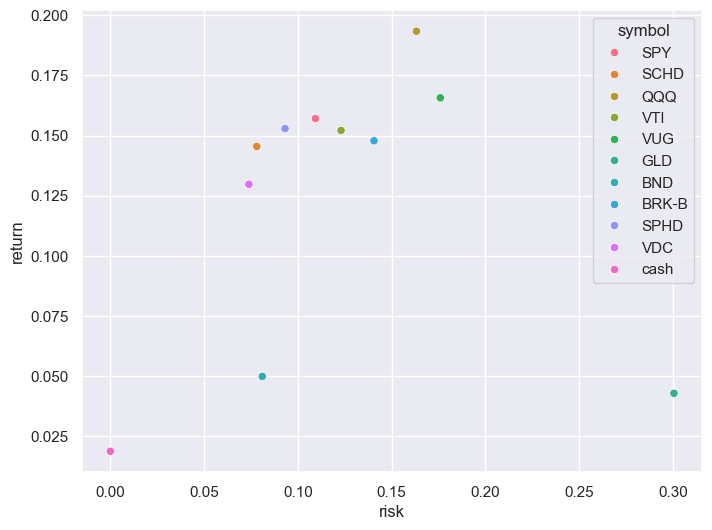

,symbol,risk,return
0,SPY,0.109369,0.157107
1,SCHD,0.078110,0.145525
2,QQQ,0.163278,0.193389
3,VTI,0.123062,0.152157
4,VUG,0.175999,0.165712
5,GLD,0.300619,0.042938
6,BND,0.081073,0.049927
7,BRK-B,0.140656,0.147883
8,SPHD,0.093195,0.152921
9,VDC,0.073940,0.129797


In [18]:
plot_riskreturn(df)
# plot_riskreturn(df.drop(['TLT', 'GLD'], axis=1))

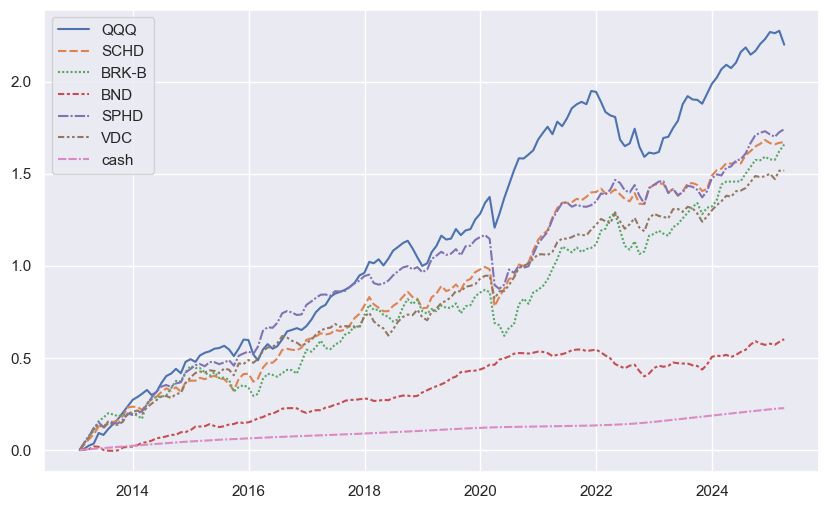

In [19]:
targets = [
    'QQQ',
    'SCHD',
    # 'SPY',
    # 'GLD',
    'BRK-B',
    # 'KO',
    'BND',
    'SPHD',
    'VDC',
    'cash',
]
plt.figure(figsize=(10, 6))
sns.lineplot(monthly_df[targets].apply(np.log))
# sns.lineplot(df[targets].apply(np.log))
plt.show()

In [20]:
@lru_cache()
def get_variants(a, b, rebal=True):
    return get_rebal_variants(df, a, b) if rebal else get_blend_variants(df, a, b)

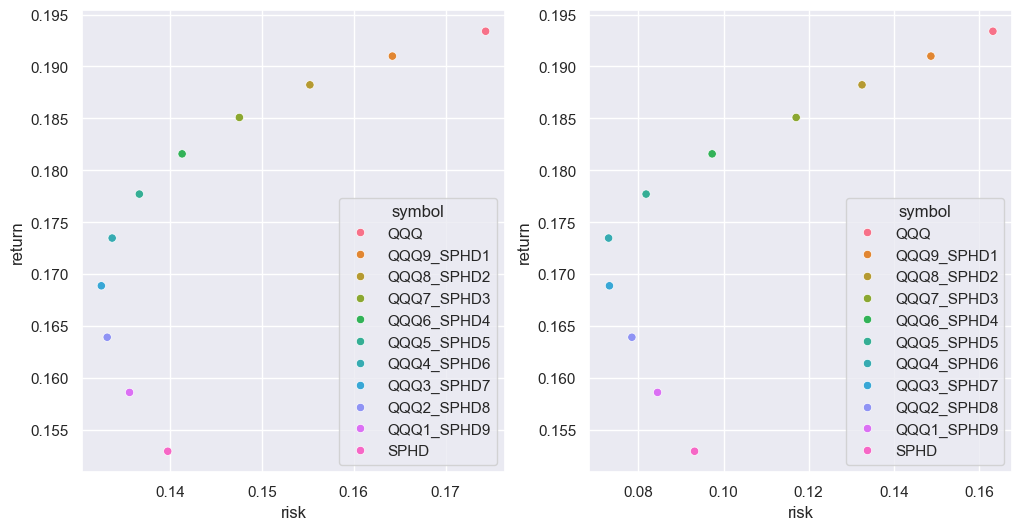

In [21]:
a, b = 'QQQ', 'SPHD'

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plot_riskreturn(get_variants(a, b), ax=ax[0], fn=calc_return_volatility)
plot_riskreturn(get_variants(a, b), ax=ax[1])
plt.show()

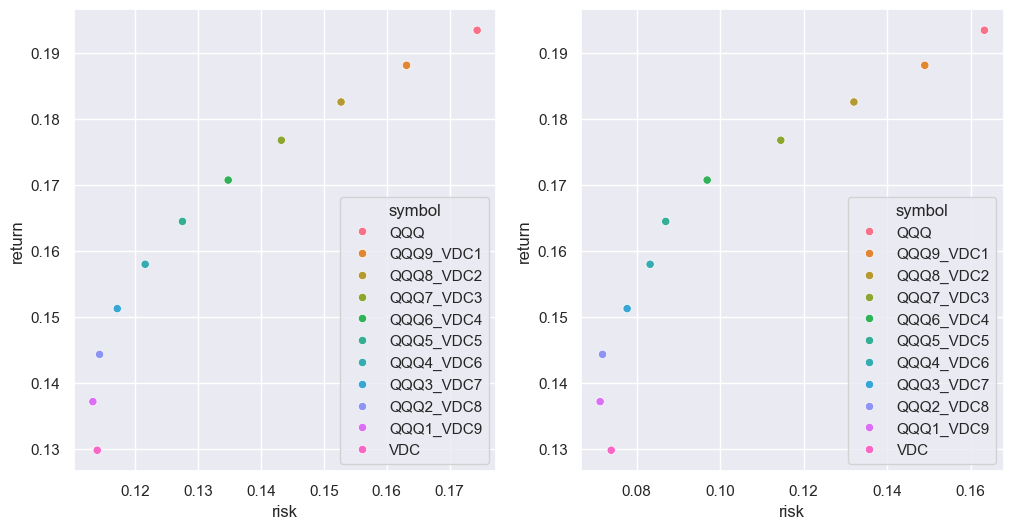

In [22]:
a, b = 'QQQ', 'VDC'

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plot_riskreturn(get_variants(a, b), ax=ax[0], fn=calc_return_volatility)
plot_riskreturn(get_variants(a, b), ax=ax[1])
plt.show()

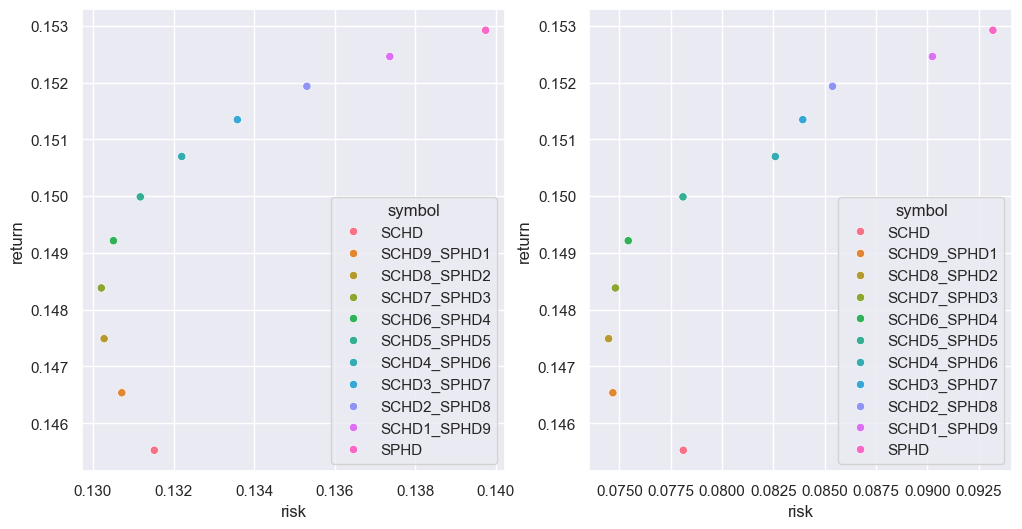

In [23]:
a, b = 'SCHD', 'SPHD'

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plot_riskreturn(get_variants(a, b), ax=ax[0], fn=calc_return_volatility)
plot_riskreturn(get_variants(a, b), ax=ax[1])
plt.show()

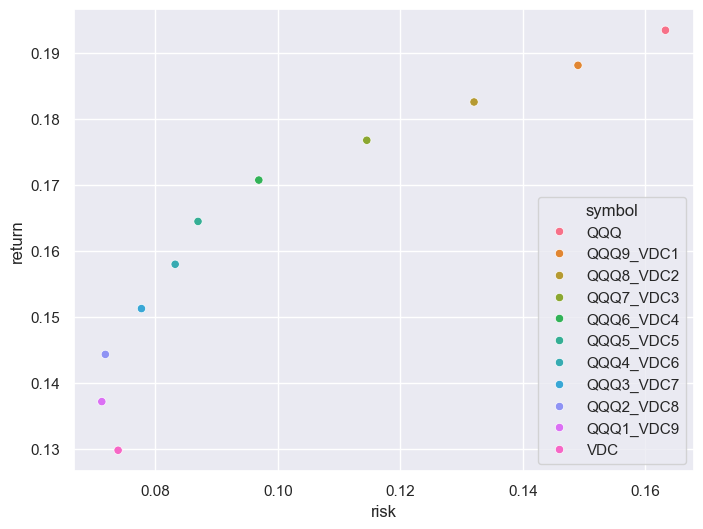

,symbol,risk,return
0,QQQ,0.163278,0.193389
1,QQQ9_VDC1,0.149004,0.188080
2,QQQ8_VDC2,0.132035,0.182527
3,QQQ7_VDC3,0.114530,0.176734
4,QQQ6_VDC4,0.096907,0.170705
5,QQQ5_VDC5,0.086981,0.164445
6,QQQ4_VDC6,0.083252,0.157957
7,QQQ3_VDC7,0.077748,0.151244
8,QQQ2_VDC8,0.071856,0.144311
9,QQQ1_VDC9,0.071278,0.137161


In [24]:
a, b = 'QQQ', 'VDC'
# plot_riskreturn(get_variants(a, b))
plot_riskreturn(get_variants(a, b))

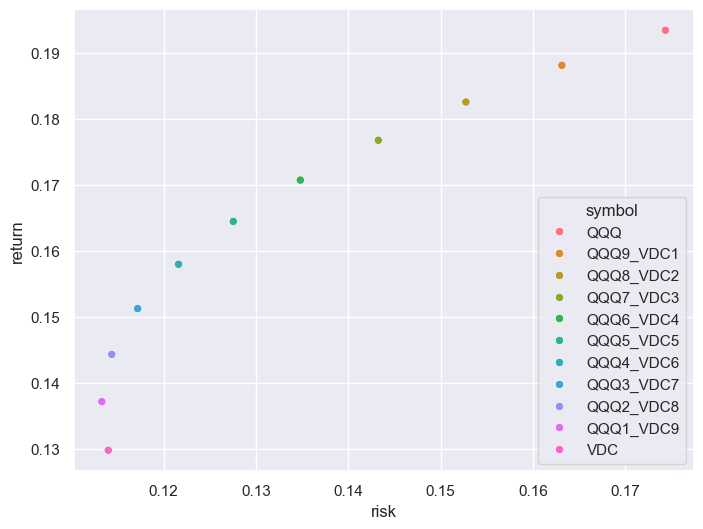

,symbol,risk,return
0,QQQ,0.174357,0.193389
1,QQQ9_VDC1,0.163142,0.188080
2,QQQ8_VDC2,0.152740,0.182527
3,QQQ7_VDC3,0.143255,0.176734
4,QQQ6_VDC4,0.134810,0.170705
5,QQQ5_VDC5,0.127547,0.164445
6,QQQ4_VDC6,0.121621,0.157957
7,QQQ3_VDC7,0.117187,0.151244
8,QQQ2_VDC8,0.114383,0.144311
9,QQQ1_VDC9,0.113309,0.137161


In [25]:
a, b = 'QQQ', 'VDC'
# plot_riskreturn(get_variants(a, b))
plot_riskreturn(get_variants(a, b), fn=calc_return_volatility)

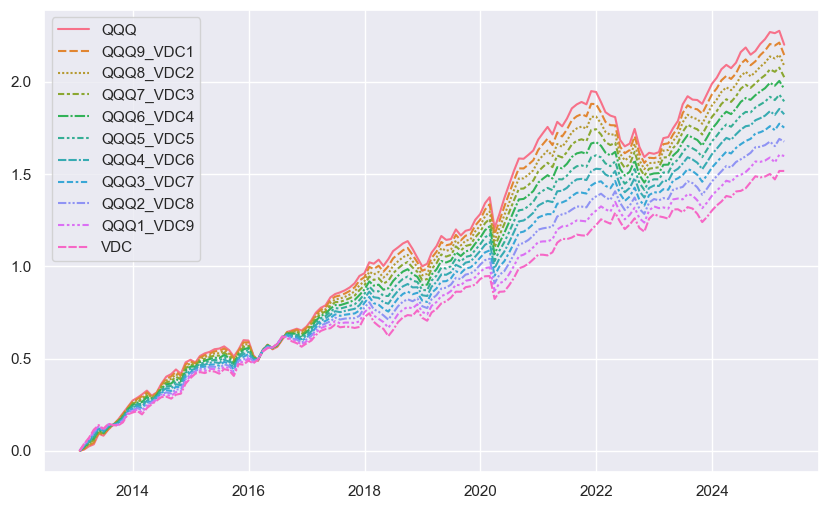

In [26]:
plt.figure(figsize=(10, 6))
sns.lineplot(get_variants('QQQ', 'VDC').resample('ME').mean().apply(np.log))
plt.show()

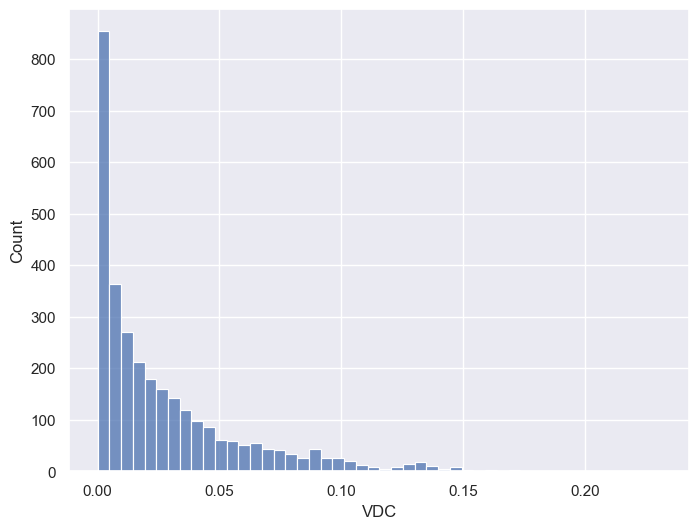

np.float64(0.07394019485652364)

In [27]:
mdd = calc_mdd(df['VDC'])
sns.histplot(mdd)
plt.show()
mdd.quantile(0.9)

In [28]:
@lru_cache(maxsize=500)
def _rebal_cache_internel(w_hashable: Tuple[Tuple[str, float], ...], name):
    _w = {_k: _v for _k, _v in w_hashable}
    return rebalance(df, _w, name)
def rebal_cache(weight, name='rebal'):
    _w = tuple(sorted(weight.items()))
    return _rebal_cache_internel(_w, name)

test_weight = {'QQQ': 2, 'SCHD': 6, 'GLD': 1, 'BND': 1}
rebal_cache(test_weight)

,rebal
date,
2013-01-02,0.989967
2013-01-03,0.990383
2013-01-04,0.990190
2013-01-07,0.987946
2013-01-08,0.986878
...,...
2025-03-07,5.005547
2025-03-10,5.001938
2025-03-11,4.950647


In [29]:
a, b, c = 'QQQ', 'SCHD', 'VDC'

rebal_all = []
for i in range(10 + 1):
    for j in range(10-i + 1):
        k = 10 - (i+j)
        name = f"{i}_{j}_{k}"
        weight = {a: i, b: j, c: k}
        print(weight)
        rebal_all.append(rebal_cache(weight, name))
rebal_all = pd.concat(rebal_all, axis=1)
rebal_all

{'QQQ': 0, 'SCHD': 0, 'VDC': 10}
{'QQQ': 0, 'SCHD': 1, 'VDC': 9}
{'QQQ': 0, 'SCHD': 2, 'VDC': 8}
{'QQQ': 0, 'SCHD': 3, 'VDC': 7}
{'QQQ': 0, 'SCHD': 4, 'VDC': 6}
{'QQQ': 0, 'SCHD': 5, 'VDC': 5}
{'QQQ': 0, 'SCHD': 6, 'VDC': 4}
{'QQQ': 0, 'SCHD': 7, 'VDC': 3}
{'QQQ': 0, 'SCHD': 8, 'VDC': 2}
{'QQQ': 0, 'SCHD': 9, 'VDC': 1}
{'QQQ': 0, 'SCHD': 10, 'VDC': 0}
{'QQQ': 1, 'SCHD': 0, 'VDC': 9}
{'QQQ': 1, 'SCHD': 1, 'VDC': 8}
{'QQQ': 1, 'SCHD': 2, 'VDC': 7}
{'QQQ': 1, 'SCHD': 3, 'VDC': 6}
{'QQQ': 1, 'SCHD': 4, 'VDC': 5}
{'QQQ': 1, 'SCHD': 5, 'VDC': 4}
{'QQQ': 1, 'SCHD': 6, 'VDC': 3}
{'QQQ': 1, 'SCHD': 7, 'VDC': 2}
{'QQQ': 1, 'SCHD': 8, 'VDC': 1}
{'QQQ': 1, 'SCHD': 9, 'VDC': 0}
{'QQQ': 2, 'SCHD': 0, 'VDC': 8}
{'QQQ': 2, 'SCHD': 1, 'VDC': 7}
{'QQQ': 2, 'SCHD': 2, 'VDC': 6}
{'QQQ': 2, 'SCHD': 3, 'VDC': 5}
{'QQQ': 2, 'SCHD': 4, 'VDC': 4}
{'QQQ': 2, 'SCHD': 5, 'VDC': 3}
{'QQQ': 2, 'SCHD': 6, 'VDC': 2}
{'QQQ': 2, 'SCHD': 7, 'VDC': 1}
{'QQQ': 2, 'SCHD': 8, 'VDC': 0}
{'QQQ': 3, 'SCHD': 0, 'VDC': 7}
{'QQQ'

,0_0_10,0_1_9,0_2_8,0_3_7,0_4_6,0_5_5,0_6_4,0_7_3,0_8_2,0_9_1,...,7_0_3,7_1_2,7_2_1,7_3_0,8_0_2,8_1_1,8_2_0,9_0_1,9_1_0,10_0_0
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.984643,0.984306,0.983969,0.983631,0.983294,0.982957,0.982619,0.982282,0.981945,0.981608,...,0.995522,0.995185,0.994848,0.994510,0.997076,0.996739,0.996402,0.998631,0.998293,1.000185
2013-01-03,0.986576,0.986227,0.985877,0.985527,0.985178,0.984828,0.984479,0.984129,0.983779,0.983430,...,0.996905,0.996556,0.996206,0.995857,0.998380,0.998030,0.997681,0.999854,0.999505,1.001328
2013-01-04,0.987597,0.987497,0.987396,0.987295,0.987194,0.987093,0.986992,0.986891,0.986789,0.986687,...,0.993751,0.993655,0.993558,0.993462,0.994622,0.994526,0.994430,0.995490,0.995395,0.996356
2013-01-07,0.985665,0.985531,0.985398,0.985264,0.985130,0.984996,0.984862,0.984727,0.984593,0.984458,...,0.991363,0.991234,0.991104,0.990974,0.992168,0.992039,0.991910,0.992970,0.992842,0.993771
2013-01-08,0.980267,0.980358,0.980448,0.980537,0.980627,0.980716,0.980805,0.980893,0.980982,0.981070,...,0.990107,0.990202,0.990298,0.990392,0.991511,0.991607,0.991703,0.992914,0.993011,0.994318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-07,4.582192,4.670700,4.757248,4.841683,4.923854,5.003609,5.080802,5.155288,5.226926,5.295578,...,7.607558,7.724734,7.837794,7.946529,8.088379,8.208424,8.323973,8.575686,8.698134,9.067009
2025-03-10,4.593187,4.683782,4.772488,4.859150,4.943612,5.025721,5.105327,5.182281,5.256438,5.327657,...,7.500695,7.619324,7.733996,7.844501,7.954289,8.075634,8.192662,8.411387,8.534973,8.869438
2025-03-11,4.528110,4.617487,4.705005,4.790509,4.873847,4.954869,5.033424,5.109368,5.182557,5.252851,...,7.405014,7.522258,7.635601,7.744833,7.854583,7.974548,8.090254,8.307861,8.430079,8.762338


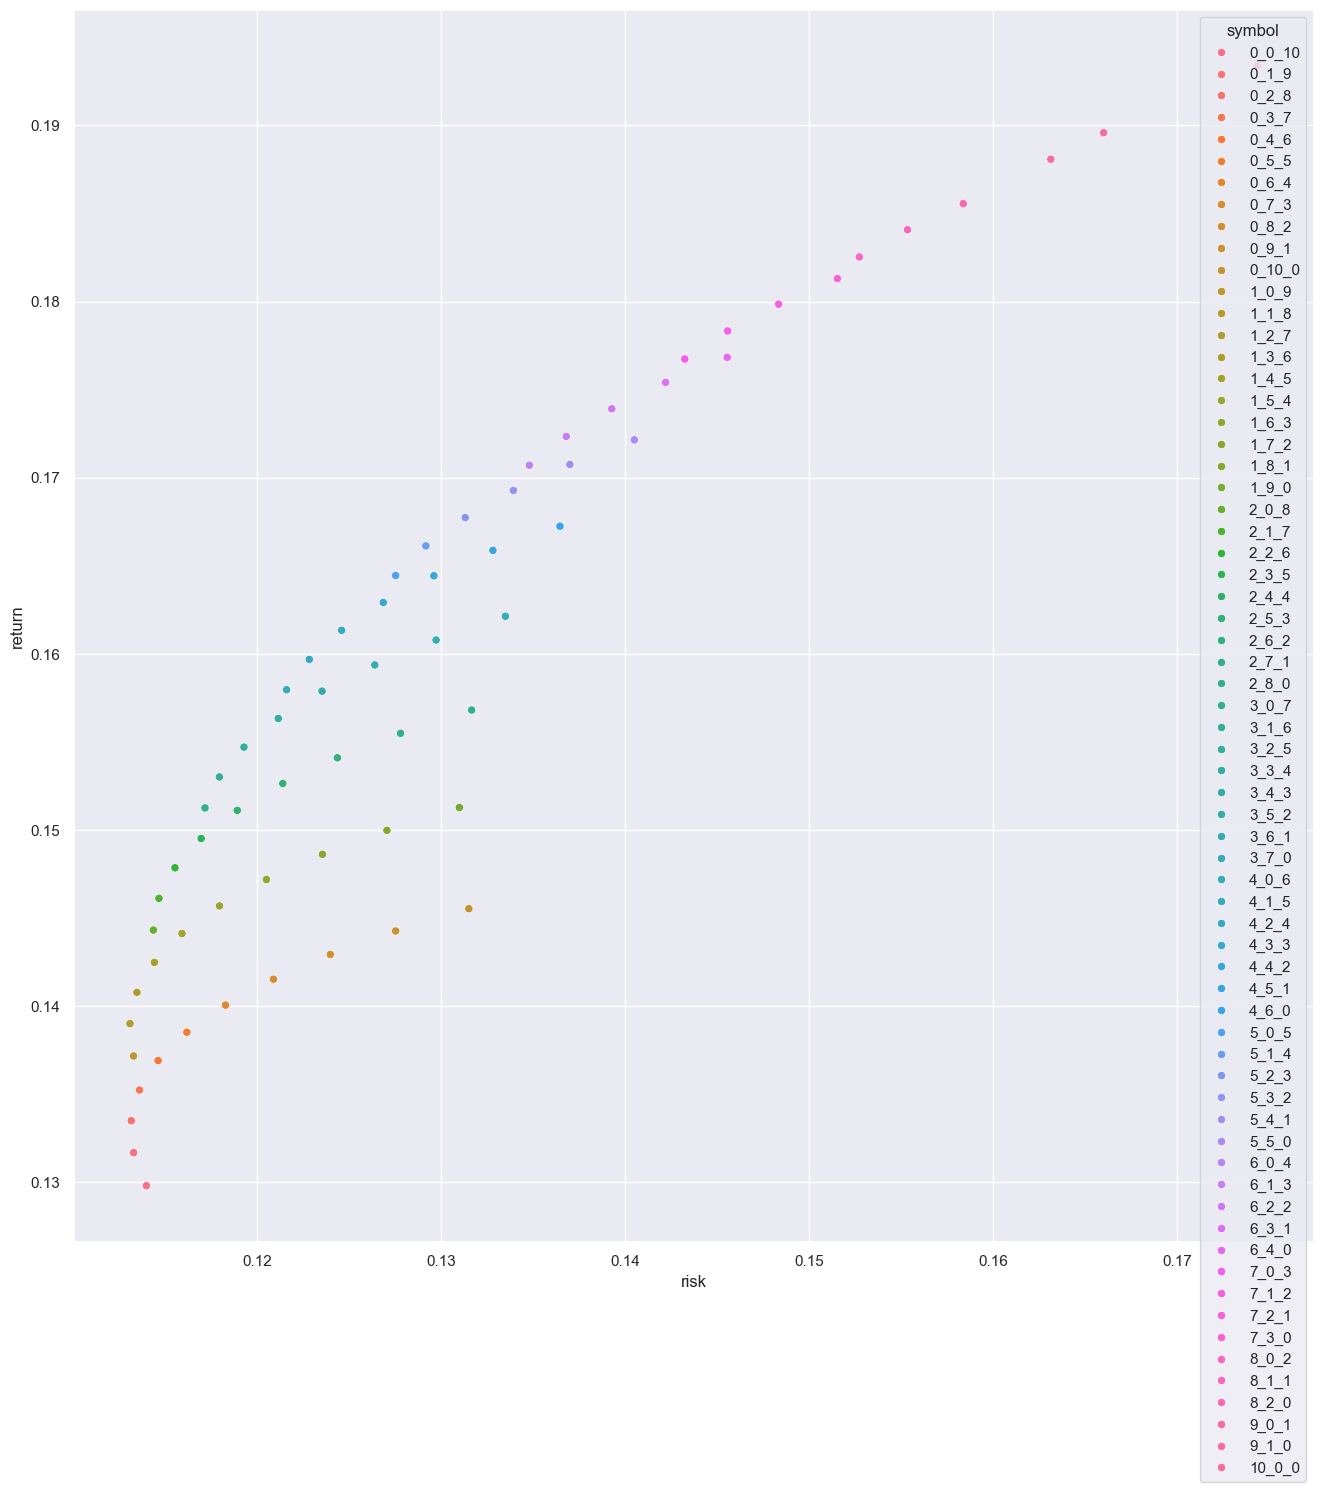

,symbol,risk,return
0,0_0_10,0.114005,0.129797
1,0_1_9,0.113311,0.131676
2,0_2_8,0.113186,0.133487
3,0_3_7,0.113632,0.135229
4,0_4_6,0.114642,0.136904
...,...,...,...
61,8_1_1,0.155355,0.184075
62,8_2_0,0.158384,0.185553
63,9_0_1,0.163142,0.188080
64,9_1_0,0.166011,0.189583


In [34]:
plt.figure(figsize=(16, 16))
# rr = plot_riskreturn(rebal_all)
rr = plot_riskreturn(rebal_all, fn=calc_return_volatility)
rr

In [33]:
rr[rr['risk'] < 0.09]

,symbol,risk,return
0,0_0_10,0.073940,0.129797
1,0_1_9,0.072380,0.131676
2,0_2_8,0.071090,0.133487
3,0_3_7,0.069769,0.135229
4,0_4_6,0.069030,0.136904
5,0_5_5,0.069374,0.138511
6,0_6_4,0.069728,0.140050
7,0_7_3,0.070398,0.141521
8,0_8_2,0.072365,0.142924
9,0_9_1,0.074810,0.144259
